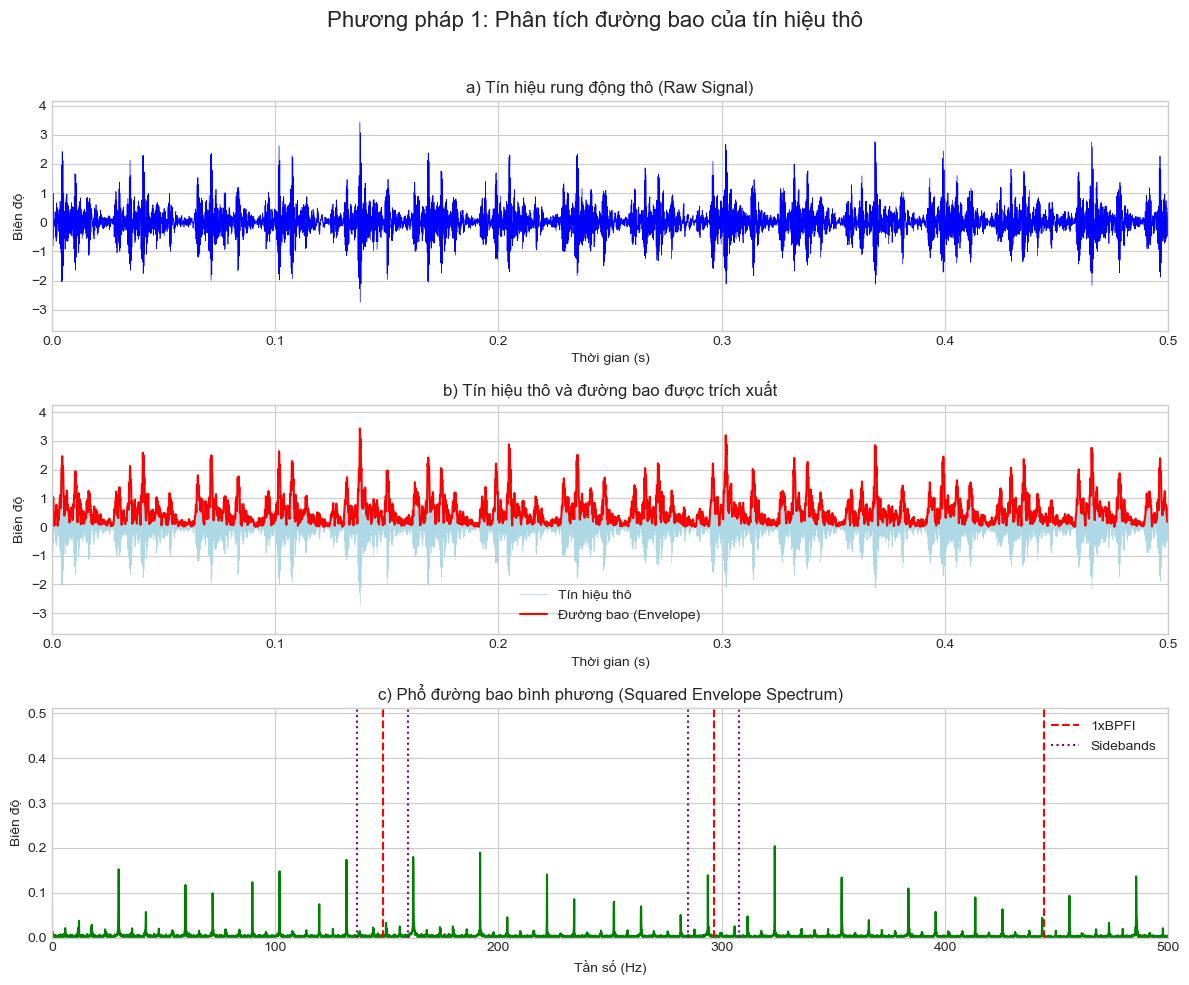

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fft import fft
from scipy.io import loadmat

# =============================================================================
# 1. TẠO TÍN HIỆU GIẢ LẬP (SIMULATED SIGNAL)
# =============================================================================
# Các tham số của hệ thống và tín hiệu
fs = 12000      # Tần số lấy mẫu (Hz)
f_bpfi = 148.16
f_shaft = 11.43

data = loadmat('CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/209_0.mat')
key_list = list(data.keys())
for key in key_list:
    if 'DE' in key:
        raw_signal = data[key].flatten()

t = np.linspace(0, 10, len(raw_signal), endpoint=False) # Trục thời gian

# =============================================================================
# 2. THỰC HIỆN PHƯƠNG PHÁP 1
# =============================================================================

# Bước 2.1: Tính toán đường bao (Envelope) bằng biến đổi Hilbert
# hilbert(signal) trả về một tín hiệu phức (analytic signal)
# Đường bao chính là module (giá trị tuyệt đối) của tín hiệu phức này
analytic_signal = hilbert(raw_signal)
envelope = np.abs(analytic_signal)

# Bước 2.2: Tính toán phổ của đường bao bình phương (Squared Envelope Spectrum - SES)
# Trừ đi giá trị trung bình để loại bỏ thành phần DC (0 Hz)
envelope_mean_removed = envelope - np.mean(envelope)

# Tính FFT của đường bao bình phương
# Sử dụng N/2 vì phổ đối xứng
N_fft = len(envelope_mean_removed)
ses_fft = fft(envelope_mean_removed**2)
ses_spectrum = 2.0/N_fft * np.abs(ses_fft[0:N_fft//2])

# Tạo trục tần số cho phổ
freq_axis = np.linspace(0.0, 1.0/(2.0* (1/fs)), N_fft//2)


# =============================================================================
# 3. TRỰC QUAN HÓA KẾT QUẢ
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Phương pháp 1: Phân tích đường bao của tín hiệu thô', fontsize=16)

# --- Đồ thị 1: Tín hiệu thô ---
axs[0].plot(t, raw_signal, color='blue', linewidth=0.5)
axs[0].set_title('a) Tín hiệu rung động thô (Raw Signal)')
axs[0].set_xlabel('Thời gian (s)')
axs[0].set_ylabel('Biên độ')
axs[0].set_xlim(0, 0.5) # Chỉ vẽ một đoạn nhỏ để thấy rõ sóng mang

# --- Đồ thị 2: Tín hiệu thô và đường bao ---
axs[1].plot(t, raw_signal, color='lightblue', linewidth=0.5, label='Tín hiệu thô')
axs[1].plot(t, envelope, color='red', linewidth=1.5, label='Đường bao (Envelope)')
axs[1].set_title('b) Tín hiệu thô và đường bao được trích xuất')
axs[1].set_xlabel('Thời gian (s)')
axs[1].set_ylabel('Biên độ')
axs[1].set_xlim(0, 0.5)
axs[1].legend()

# --- Đồ thị 3: Phổ đường bao bình phương (SES) ---
axs[2].plot(freq_axis, ses_spectrum, color='green')
axs[2].set_title('c) Phổ đường bao bình phương (Squared Envelope Spectrum)')
axs[2].set_xlabel('Tần số (Hz)')
axs[2].set_ylabel('Biên độ')
axs[2].set_xlim(0, 500) # Giới hạn trục tần số để dễ quan sát
axs[2].set_ylim(0, np.max(ses_spectrum)*1.1) # Tự động điều chỉnh trục y

# Vẽ các đường đánh dấu tần số hư hỏng để kiểm tra
# Đánh dấu BPFI và các hài
for i in range(1, 4):
    axs[2].axvline(x=f_bpfi * i, linestyle='--', color='red', label=f'{i}xBPFI' if i==1 else "")
# Đánh dấu các dải biên (sidebands) xung quanh BPFI
for i in range(1, 3):
    axs[2].axvline(x=f_bpfi * i - f_shaft, linestyle=':', color='purple', label='Sidebands' if i==1 else "")
    axs[2].axvline(x=f_bpfi * i + f_shaft, linestyle=':', color='purple')

axs[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Đang tạo dữ liệu giả lập...


100%|██████████| 10/10 [00:00<00:00, 82.34it/s]

Hình dạng của mảng dữ liệu: (10, 120000)


Hình dạng của mảng phổ kết quả: (10, 60000)


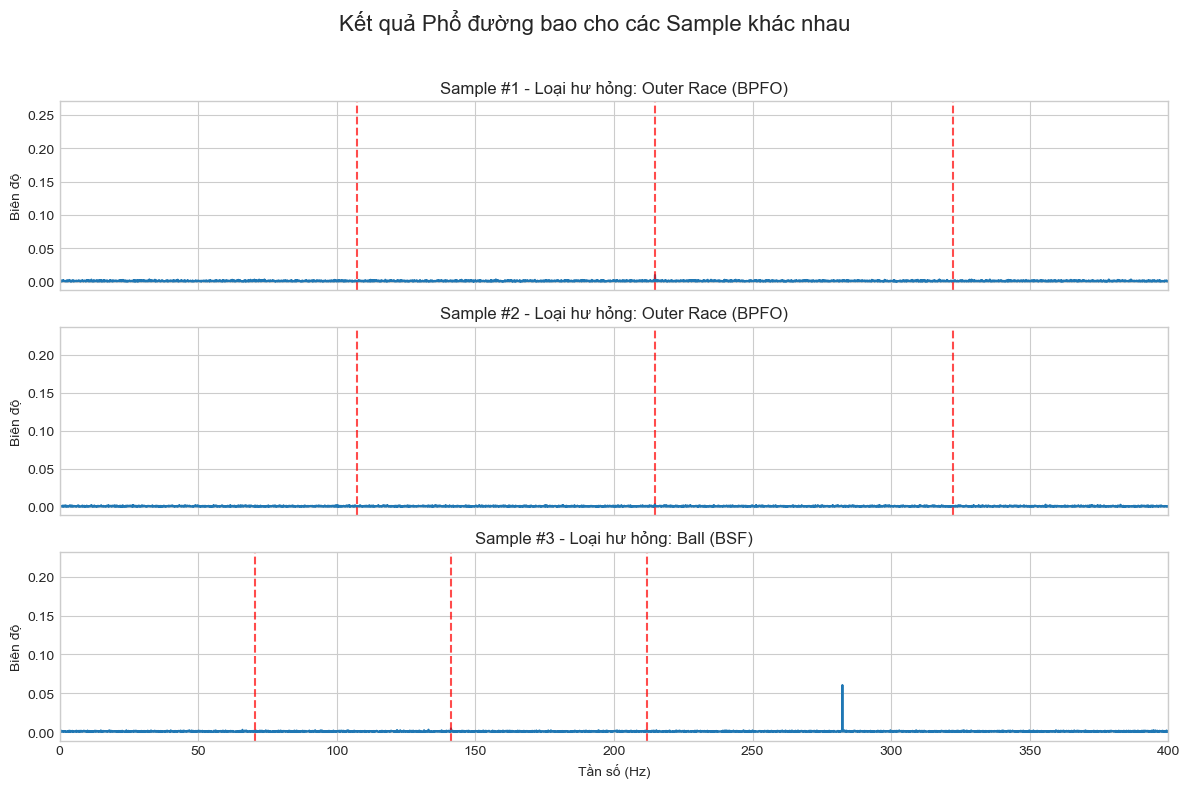

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fft import fft
from tqdm import tqdm # Thư viện để hiển thị thanh tiến trình (tùy chọn nhưng hữu ích)

def batch_envelope_analysis(signals, fs):
    """
    Thực hiện Phương pháp 1 (Phân tích đường bao) cho một loạt các tín hiệu.

    Tham số:
    ----------
    signals : numpy.ndarray
        Một mảng NumPy 2D có hình dạng [num_samples, sample_length].
        Mỗi hàng là một tín hiệu rung động.
    fs : int
        Tần số lấy mẫu của các tín hiệu (Hz).

    Trả về:
    -------
    freq_axis : numpy.ndarray
        Mảng 1D chứa trục tần số cho các phổ.
    ses_spectra : numpy.ndarray
        Một mảng NumPy 2D có hình dạng [num_samples, N_fft//2].
        Mỗi hàng là phổ đường bao bình phương (SES) của tín hiệu tương ứng.
    """
    num_samples, sample_length = signals.shape

    analytic_signals = hilbert(signals, axis=-1)
    envelopes = np.abs(analytic_signals)

    envelopes_mean_removed = envelopes - envelopes.mean(axis=1, keepdims=True)

    ses_ffts = fft(envelopes_mean_removed**2, axis=-1)

    N_fft = sample_length
    ses_spectra = 2.0/N_fft * np.abs(ses_ffts[:, 0:N_fft//2])

    freq_axis = np.linspace(0.0, 0.5 * fs, N_fft//2)

    return freq_axis, ses_spectra

# =============================================================================
# VÍ DỤ SỬ DỤNG
# =============================================================================
if __name__ == '__main__':
    # --- 1. Tạo dữ liệu giả lập cho N samples ---
    num_samples_to_generate = 10
    fs = 12000
    T = 10
    sample_length = int(fs * T)
    t = np.linspace(0, T, sample_length, endpoint=False)

    # Tần số đặc trưng
    f_carrier = 2500
    f_shaft = 29.5
    
    # Tạo 3 loại hư hỏng khác nhau để minh họa
    fault_frequencies = {
        'Inner Race (BPFI)': 158.0,
        'Outer Race (BPFO)': 107.4,
        'Ball (BSF)': 70.6
    }
    
    all_signals = []
    all_labels = []

    print("Đang tạo dữ liệu giả lập...")
    # Sử dụng tqdm để có thanh tiến trình đẹp mắt
    for i in tqdm(range(num_samples_to_generate)):
        # Chọn ngẫu nhiên một loại hư hỏng
        fault_type = np.random.choice(list(fault_frequencies.keys()))
        f_fault = fault_frequencies[fault_type]

        # Tạo tín hiệu điều biến
        if fault_type == 'Inner Race (BPFI)':
            # Có điều biến bởi f_shaft
            modulating = (1 + 0.7 * np.cos(2 * np.pi * f_shaft * t)) * np.sin(2 * np.pi * f_fault * t)
        else:
            # Các loại khác không có điều biến f_shaft rõ ràng
            modulating = np.sin(2 * np.pi * f_fault * t)
            
        carrier = np.sin(2 * np.pi * f_carrier * t)
        
        # Thêm nhiễu với mức độ ngẫu nhiên
        noise_level = 0.3 * np.random.rand() + 0.1
        signal = modulating * carrier + noise_level * np.random.randn(sample_length)
        
        all_signals.append(signal)
        all_labels.append(fault_type)

    # Chuyển danh sách các tín hiệu thành một mảng NumPy 2D
    signals_batch = np.array(all_signals)
    print(f"Hình dạng của mảng dữ liệu: {signals_batch.shape}")

    # --- 2. Áp dụng hàm xử lý hàng loạt ---
    freq_axis, all_ses_spectra = batch_envelope_analysis(signals_batch, fs)
    print(f"Hình dạng của mảng phổ kết quả: {all_ses_spectra.shape}")

    # --- 3. Trực quan hóa kết quả cho một vài sample ---
    num_samples_to_plot = 3
    fig, axs = plt.subplots(num_samples_to_plot, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Kết quả Phổ đường bao cho các Sample khác nhau', fontsize=16)

    for i in range(num_samples_to_plot):
        axs[i].plot(freq_axis, all_ses_spectra[i, :])
        axs[i].set_title(f'Sample #{i+1} - Loại hư hỏng: {all_labels[i]}')
        axs[i].set_ylabel('Biên độ')
        axs[i].set_xlim(0, 400)
        # Đánh dấu tần số hư hỏng tương ứng
        f_fault_actual = fault_frequencies[all_labels[i]]
        for j in range(1, 4):
            axs[i].axvline(x=f_fault_actual * j, linestyle='--', color='red', alpha=0.7)

    axs[-1].set_xlabel('Tần số (Hz)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
import torch
import torch.nn as nn

class TFAM1DCNN_simplified(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(TFAM1DCNN_simplified, self).__init__()

        # --- Khối 1 ---
        self.block1 = nn.Sequential(
            # Lớp 1: Convolution
            # in_channels=1, out_channels=16, kernel_size=64, stride=16, padding=24
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=64, stride=16, padding=24),
            # Lớp 2: BatchNorm
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            # Lớp 3: Dropout
            nn.Dropout(p=dropout_rate),
            # Lớp 4: Pooling
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Output shape: (batch, 16, 64)

        # --- Khối 2 ---
        self.block2 = nn.Sequential(
            # Lớp 5: Convolution
            # in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Lớp 6: BatchNorm
            nn.BatchNorm1d(num_features=32),
            nn.ReLU()
            # Lớp 7: TFAM (Bỏ qua)
        )
        # Output shape: (batch, 32, 64)

        # --- Khối 3 ---
        self.block3 = nn.Sequential(
            # Lớp 8: Convolution
            # in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # Lớp 9: BatchNorm
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            # Lớp 10: Pooling (sửa stride=2)
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Output shape: (batch, 64, 32)

        # --- Khối 4 ---
        self.block4 = nn.Sequential(
            # Lớp 11: Convolution
            # in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # Lớp 12: BatchNorm
            nn.BatchNorm1d(num_features=64),
            nn.ReLU()
            # Lớp 13: TFAM (Bỏ qua)
        )
        # Output shape: (batch, 64, 32)

        # --- Khối Residual ---
        self.residual_block = nn.Sequential(
            # Lớp 14: Convolution
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # Lớp 15: BatchNorm
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            # Lớp 16: TFAM (Bỏ qua)
            # Lớp 17: Convolution
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=64) # BN trước khi cộng
        )
        self.residual_activation = nn.ReLU()
        # Output shape: (batch, 64, 32)

        # --- Khối cuối ---
        self.final_block = nn.Sequential(
            # Lớp 19: Pooling
            nn.MaxPool1d(kernel_size=2, stride=2),
            # Lớp 20: Global Average Pooling
            nn.AdaptiveAvgPool1d(1)
        )
        # Output shape: (batch, 64, 1)

        # --- Lớp phân loại ---
        # Lớp 21: Dense (Linear)
        self.classifier = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 2048)
        x = self.block1(x)
        # x shape: (batch, 16, 64)
        x = self.block2(x)
        # x shape: (batch, 32, 64)
        x = self.block3(x)
        # x shape: (batch, 64, 32)
        x = self.block4(x)
        # x shape: (batch, 64, 32)

        # Lưu lại đầu vào cho kết nối tắt
        residual_input = x
        
        # Đi qua khối residual
        x_res = self.residual_block(x)
        
        # Lớp 18: Add
        x = x_res + residual_input
        x = self.residual_activation(x)
        # x shape: (batch, 64, 32)

        # Đi qua khối cuối
        x = self.final_block(x)
        # x shape: (batch, 64, 1)

        # Flatten trước khi đưa vào lớp Linear
        # x.view(x.size(0), -1) tương đương với flatten
        x = x.view(x.size(0), -1)
        # x shape: (batch, 64)

        # Lớp phân loại
        output = self.classifier(x)
        # output shape: (batch, num_classes)
        
        return output


Đang thực hiện Cepstrum Prewhitening cho 2 tín hiệu...
Hoàn tất tiền xử lý!


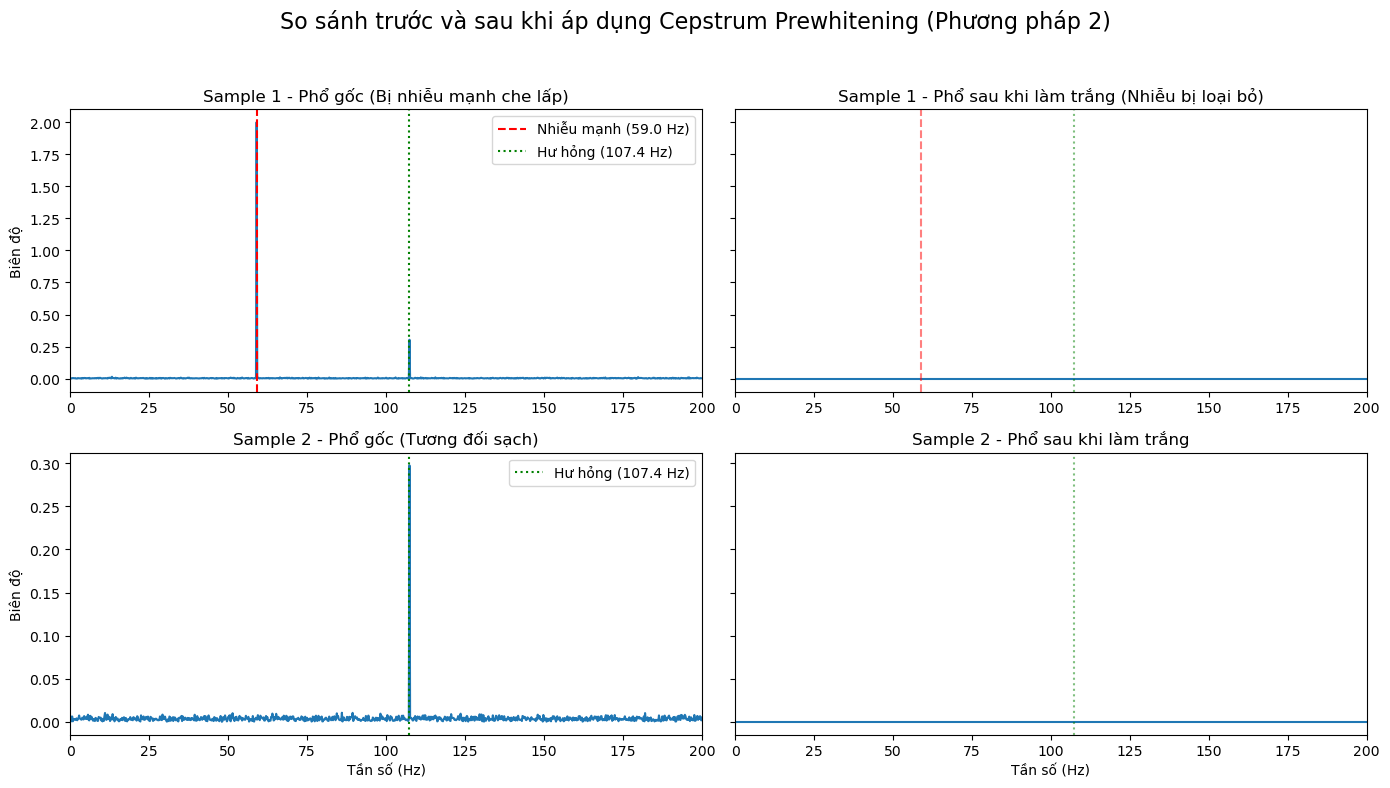

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from tqdm import tqdm

def batch_cepstrum_prewhitening(signals):
    """
    Thực hiện tiền xử lý bằng phương pháp Cepstrum Prewhitening (Phương pháp 2)
    cho một loạt các tín hiệu.

    Phương pháp này "làm trắng" phổ bằng cách loại bỏ thông tin biên độ
    và chỉ giữ lại thông tin pha, giúp làm nổi bật các thành phần có tính xung.

    Tham số:
    ----------
    signals : numpy.ndarray
        Một mảng NumPy 2D có hình dạng [num_samples, sample_length].
        Mỗi hàng là một tín hiệu rung động thô.

    Trả về:
    -------
    whitened_signals : numpy.ndarray
        Một mảng NumPy 2D có cùng hình dạng với tín hiệu đầu vào.
        Mỗi hàng là tín hiệu tương ứng đã được làm trắng.
    """
    print(f"Đang thực hiện Cepstrum Prewhitening cho {signals.shape[0]} tín hiệu...")

    # --- Bước 1: Tính FFT của tất cả các tín hiệu ---
    # axis=-1 để thực hiện FFT trên từng hàng
    signals_fft = fft(signals, axis=-1)

    # --- Bước 2: "Làm trắng" phổ ---
    # Lấy module (biên độ) của phổ
    magnitude = np.abs(signals_fft)
    
    # Để tránh chia cho 0, thay thế các giá trị biên độ bằng 0 bằng một số rất nhỏ (epsilon)
    epsilon = 1e-12
    magnitude[magnitude < epsilon] = epsilon

    # Tạo phổ đã được làm trắng bằng cách chia mỗi thành phần phức cho biên độ của nó.
    # Kết quả là một phổ phức mới mà tất cả các thành phần đều có biên độ bằng 1.
    whitened_fft = signals_fft / magnitude

    # --- Bước 3: Biến đổi ngược về miền thời gian ---
    # axis=-1 để thực hiện IFFT trên từng hàng
    whitened_signals_complex = ifft(whitened_fft, axis=-1)
    
    # Tín hiệu cuối cùng là phần thực của kết quả
    whitened_signals = np.real(whitened_signals_complex)
    
    print("Hoàn tất tiền xử lý!")
    return whitened_signals

# =============================================================================
# VÍ DỤ SỬ DỤNG
# =============================================================================
if __name__ == '__main__':
    # --- 1. Tạo dữ liệu giả lập phức tạp ---
    # Tín hiệu này sẽ có cả hư hỏng và một thành phần nhiễu có cấu trúc mạnh
    num_samples = 2
    fs = 12000
    T = 5
    sample_length = int(fs * T)
    t = np.linspace(0, T, sample_length, endpoint=False)

    # Tần số hư hỏng (yếu)
    f_fault = 107.4 # BPFO

    # Tần số nhiễu có cấu trúc (mạnh) - ví dụ từ độ lỏng
    f_noise_strong = 29.5 * 2 # 2xfr

    # Tạo tín hiệu
    fault_signal = 0.3 * np.sin(2 * np.pi * f_fault * t) # Tín hiệu hư hỏng yếu
    noise_signal = 2.0 * np.sin(2 * np.pi * f_noise_strong * t) # Nhiễu có cấu trúc mạnh
    
    # Tín hiệu cuối cùng là tổng của tín hiệu hư hỏng, nhiễu mạnh và nhiễu ngẫu nhiên
    # Chúng ta sẽ tạo 2 sample để minh họa
    signal_1 = fault_signal + noise_signal + 0.5 * np.random.randn(sample_length)
    signal_2 = fault_signal + 0.5 * np.random.randn(sample_length) # Sample 2 không có nhiễu mạnh
    
    signals_batch = np.array([signal_1, signal_2])

    # --- 2. Áp dụng hàm tiền xử lý ---
    whitened_signals_batch = batch_cepstrum_prewhitening(signals_batch)

    # --- 3. Trực quan hóa để so sánh ---
    # Chúng ta sẽ so sánh phổ của tín hiệu trước và sau khi làm trắng
    
    # Tính phổ của tín hiệu gốc
    original_fft = fft(signals_batch, axis=-1)
    original_spectra = 2.0/sample_length * np.abs(original_fft[:, 0:sample_length//2])
    
    # Tính phổ của tín hiệu đã làm trắng
    whitened_fft = fft(whitened_signals_batch, axis=-1)
    whitened_spectra = 2.0/sample_length * np.abs(whitened_fft[:, 0:sample_length//2])
    
    freq_axis = np.linspace(0.0, 0.5 * fs, sample_length//2)

    # Vẽ đồ thị
    fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='row')
    fig.suptitle('So sánh trước và sau khi áp dụng Cepstrum Prewhitening (Phương pháp 2)', fontsize=16)

    # --- Sample 1: Có nhiễu mạnh ---
    axs[0, 0].plot(freq_axis, original_spectra[0, :])
    axs[0, 0].set_title('Sample 1 - Phổ gốc (Bị nhiễu mạnh che lấp)')
    axs[0, 0].set_xlim(0, 200)
    axs[0, 0].axvline(x=f_noise_strong, color='red', linestyle='--', label=f'Nhiễu mạnh ({f_noise_strong:.1f} Hz)')
    axs[0, 0].axvline(x=f_fault, color='green', linestyle=':', label=f'Hư hỏng ({f_fault:.1f} Hz)')
    axs[0, 0].legend()
    axs[0, 0].set_ylabel('Biên độ')

    axs[0, 1].plot(freq_axis, whitened_spectra[0, :])
    axs[0, 1].set_title('Sample 1 - Phổ sau khi làm trắng (Nhiễu bị loại bỏ)')
    axs[0, 1].set_xlim(0, 200)
    axs[0, 1].axvline(x=f_noise_strong, color='red', linestyle='--', alpha=0.5)
    axs[0, 1].axvline(x=f_fault, color='green', linestyle=':', alpha=0.5)


    # --- Sample 2: Không có nhiễu mạnh ---
    axs[1, 0].plot(freq_axis, original_spectra[1, :])
    axs[1, 0].set_title('Sample 2 - Phổ gốc (Tương đối sạch)')
    axs[1, 0].set_xlim(0, 200)
    axs[1, 0].axvline(x=f_fault, color='green', linestyle=':', label=f'Hư hỏng ({f_fault:.1f} Hz)')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Tần số (Hz)')
    axs[1, 0].set_ylabel('Biên độ')

    axs[1, 1].plot(freq_axis, whitened_spectra[1, :])
    axs[1, 1].set_title('Sample 2 - Phổ sau khi làm trắng')
    axs[1, 1].set_xlim(0, 200)
    axs[1, 1].axvline(x=f_fault, color='green', linestyle=':', alpha=0.5)
    axs[1, 1].set_xlabel('Tần số (Hz)')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [1]:
a = 'helo'
type(a)

str

In [2]:
a = 1024
b = int(a**(1/2))

In [3]:
b

32